# A song recommendation engine using the Spotify API

## Motivation

Have you ever wondered how Netflix knows what movies you might like, or Amazon decides what products to show you next? Trying to predict what consumers want and using that to personalize content is a critical part of a modern, digital business model -- it’s no longer just for Facebook and Twitter. Soon, we may even start to see personalized newspaper articles or targeted computer-generated art and music.

Algorithms to model user preferences, called recommender systems, are all around us, and can be incredibly complex. There are two main types of information that recommender systems draw on: features of the content (highly-rated products that are on sale right now), and features of the consumers (Bluetooth headphones similar to the ones you shopped for last week, or products that other college students are buying). Weighting these two types of information is a major challenge of creating a good recommender system.

## Creating the dataset 

We can use data provided by the Spotify API to demonstrate using content features to make recommendations. The question we’re trying to answer: given a song a user likes, what are some similar songs that the user might also like? We’ll just use content information (features about the songs) to construct our recommendation engine. 

To tackle this problem, I’ve chosen to use data about music using the Spotify API. The Spotify API allows one to fetch metadata in JSON format about song tracks in Spotify’s music catalog. This metadata includes features like the “danceability”, “energy”, “acousticness”, “instrumentalness”, and “liveness” of tracks that we can use to assess song similarity. 

The richness of this metadata, and the Spotify-specific terms, help us avoid a common pitfall of recommender systems: providing suggestions that are a little too obvious. For example, if one of our features was the song artist’s name, our recommender system’s best recommendations might be songs by the same artist, and perhaps off the same album - but consumers are likely familiar with an artist’s entire work, so these recommendations aren't very useful.  

To create the dataset, I’ve chosen to get help from Spotipy, a lightweight Python wrapper for the Spotify API (documentation available __[here](http://spotipy.readthedocs.io/en/latest/#)__). This requires installing Spotipy (available via pip!) and obtaining a Client ID and Client Secret via the __[Spotify Developer Portal](https://developer.spotify.com/web-api/)__. 


In [ ]:
# Requirements: requests, spotipy (available via pip)

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Fill in your own client ID and client secret! 
client_id = 'CLIENT_ID'
client_secret = 'CLIENT_SECRET'

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

Now that we can use the API, I created 20 search terms based on words I thought commonly appeared in song titles. 

In [ ]:
search_terms = [
    'hello', 'world', 'sun', 'rain', 'night', 'day', 'love', 'fight',
    'sleep', 'young', 'one', 'light', 'find', 'believe', 'home', 'dark', 'you',
    'me', 'us', 'heart'
]

We can use the search functionality of Spotipy with these search terms to pull the first 100 songs associated with each search term for a total of about 2000 songs, get their audio features, and write all the data to a CSV file. (I recommend adding pauses to avoid running into rate-limiting problems with the API.)

In [ ]:
import csv 

search_limit = 50
output_file = open('songs.csv', 'w')

for term in search_terms:
    for page in [0, 1]: 
        offset = search_limit*page
        search_result = sp.search(term, type='track', limit=search_limit, offset=offset)

        for item in search_result['tracks']['items']:
            track_name = sp.track(item['id'])['name'].replace(',', '')

            artist = sp.track(item['id'])['artists'][0]
            track_artist = artist['name'].replace(',', '')

            track_audio_features = sp.audio_features(item['id'])[0]

            if (track_name and track_artist and track_audio_features):
                row = ','.join([
                    track_name, 
                    track_artist, 
                    track_audio_features['id'],
                    str(track_audio_features['danceability']),
                    str(track_audio_features['energy']),
                    str(track_audio_features['key']),
                    str(track_audio_features['loudness']),
                    str(track_audio_features['mode']),
                    str(track_audio_features['speechiness']),
                    str(track_audio_features['acousticness']),
                    str(track_audio_features['instrumentalness']),
                    str(track_audio_features['liveness']),
                    str(track_audio_features['valence']),
                    str(track_audio_features['tempo']),
                ])

                output_file.write('{0}\n'.format(row))

output_file.close()

## Extracting features

We’ll use pandas to load and work with our data throughout the rest of the tutorial. To assess similarity, we’ll be using: danceability, energy, mode, speechiness, acousticness, instrumentalness, liveness, and valence. 

From the __[Spotify API Reference](https://developer.spotify.com/web-api/get-audio-features/)__:

-  **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
-  **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
-  **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
-  **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
-  **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
-  **Instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
-  **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
-  **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

All of these features are floats between 0.0 and 1.0 (though mode represents a binary encoding), so we don’t need to transform them further. Because we’ll be calculating similarity using distance moving forward, normalization to values between 0 and 1 is especially important so that some features aren’t artificially heavier-weighted in that calculation. 


In [2]:
# Requirement: pandas 

import pandas as pd 

data = pd.read_csv('songs.csv', 
                   names=[
                       'Name', 
                       'Artists', 
                       'ID', 
                       'Danceability',
                       'Energy', 
                       'Key', 
                       'Loudness', 
                       'Mode', 
                       'Speechiness', 
                       'Acousticness', 
                       'Instrumentalness', 
                       'Liveness', 
                       'Valence', 
                       'Tempo'
                   ])

for col in ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 
'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo']:
    data[col] = pd.to_numeric(data[col])

print(data.shape)
print(data.columns)
print(data.head())

(1991, 14)
Index(['Name', 'Artists', 'ID', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo'],
      dtype='object')
              Name         Artists                      ID  Danceability  \
0            Hello           Adele  0ENSn4fwAbCGeFGVUbXEU3         0.481   
1            Hello           Adele  4sPmO7WMQUAf45kwMOtONw         0.481   
2  Hello Beautiful   Noah Schnacky  4pYd8dIohiqc3KsxSRqf0w         0.504   
3      Hello There  Dillon Francis  7fyx7nBQTEtYrfXc0UgUYs         0.798   
4        Hello Ego      Jhene Aiko  2kt06ZsD735FYBZO8yAAQs         0.692   

   Energy  Key  Loudness  Mode  Speechiness  Acousticness  Instrumentalness  \
0   0.451    5    -6.095     0       0.0347        0.3360               0.0   
1   0.451    5    -6.095     0       0.0347        0.3360               0.0   
2   0.472    9    -6.925     1       0.0404        0.5400               0.0   
3   0.720  

To visualize different features and get a sense of how they relate to the subset of tracks we’re using, we can generate histograms. We want our features to be well-distributed (have high variance), which will indicate that they’re informative features. 

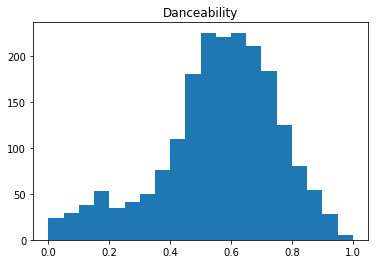

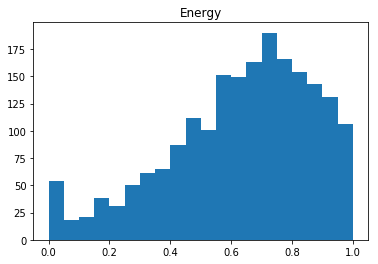

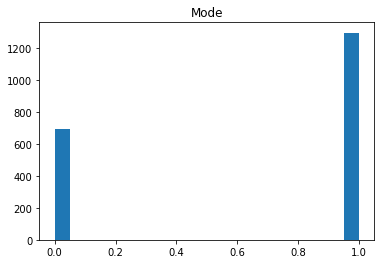

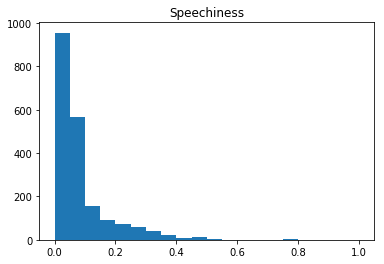

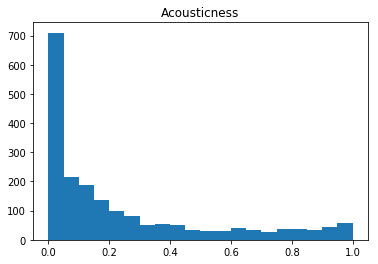

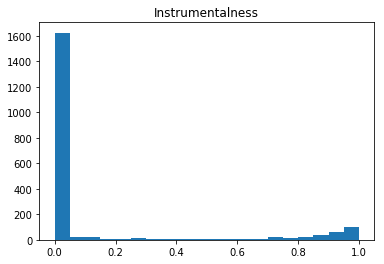

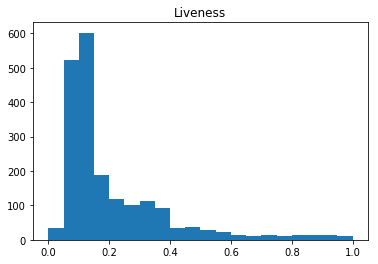

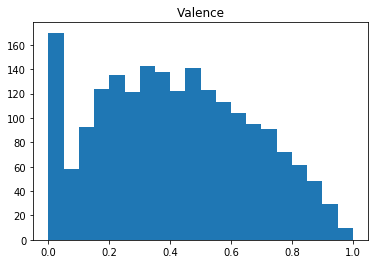

In [12]:
# Requirement: matplotlib

import matplotlib as mpl
import matplotlib.pyplot as plt

for col in ['Danceability', 'Energy', 'Mode', 'Speechiness', 
'Acousticness', 'Instrumentalness', 'Liveness', 'Valence']:
    plt.hist(data[col], bins=list(map(lambda x: x*0.05, range(0, 21))))
    plt.title(col)
    plt.show()

Visualizing the features (by changing out the column name) shows that all are fairly informative, and so we’ll proceed with using all of them to compute similarity.

## Calculating similarity 

Because we’re working with real-valued data, we can use Euclidean distance as a similarity metric. Given a song in our Dataframe that we want to generate recommendations for, we’ll compute the Euclidean distance between that song and all songs in the Dataframe, and then return the closest songs as recommendations. Note that the first few recommendations will be the same song we requested - that's how we know it's working!  


In [3]:
def euclidean_dist(song1, song2):
    sum = 0
    for col in ['Danceability', 'Energy', 'Mode', 'Speechiness', 'Acousticness', 
    'Instrumentalness', 'Liveness', 'Valence']:
        sum += (song1[col] - song2[col])**2
    return sum**0.5

def generate_euclidean_dist_recommendations(data, trackID):
    requested_song = data[data['ID'] == trackID]
    data['distances'] = data.apply(
        lambda song: euclidean_dist(requested_song, song), 
        axis='columns'
    )
    sorted_songs = data.sort_values(by=['distances'])
    first_10 = sorted_songs.head(10)
    filtered = first_10.filter(items=['Name', 'Artists'])
    return filtered

Let’s test it out! Let's get song recommendations for “Hello” by Adele: 

In [4]:
print(generate_euclidean_dist_recommendations(data, '0ENSn4fwAbCGeFGVUbXEU3'))

                   Name             Artists
0                 Hello               Adele
1                 Hello               Adele
1798                 Us           James Bay
1207    FIND YOUR WINGS  Tyler  The Creator
920       Forever Young          Alphaville
1191  Red Light Special                 TLC
360          After Rain      Dermot Kennedy
1515         Dark Horse        Devin Dawson
982           Young God              Halsey
1810    Help Us To Love          Tori Kelly


Cosine similarity is also a reasonable choice for a similarity metric - let’s test that out too: 

In [57]:
def cosine_similarity(song1, song2):
    numerator = 0
    song1_sum = 0
    song2_sum = 0

    for col in ['Danceability', 'Energy', 'Mode', 'Speechiness', 'Acousticness', 
    'Instrumentalness', 'Liveness', 'Valence']:
        numerator += song1[col]*song2[col]
        song1_sum += song1[col]**2
        song2_sum += song2[col]**2

    return numerator/((song1_sum**0.5)*(song2_sum**0.5))

def generate_cosine_sim_recommendations(data, trackID):
    requested_song = data[data['ID'] == trackID]
    data['distances'] = data.apply(
        lambda song: cosine_similarity(requested_song, song), axis='columns')
    sorted_songs = data.sort_values(by=['distances'], ascending=False)
    return sorted_songs.head(10).filter(items=['Name', 'Artists'])

print(generate_cosine_sim_recommendations(data, '0ENSn4fwAbCGeFGVUbXEU3'))

                                            Name             Artists
0                                          Hello               Adele
1                                          Hello               Adele
1515                                  Dark Horse        Devin Dawson
1511                                Dark Fantasy          Kanye West
1068                                       Slide       Calvin Harris
501   Marvelous Day (feat. Lil Uzi Vert & Gunna)               Kap G
992                               1-800-273-8255               Logic
1945                                       Heart         Omar Apollo
988      Annoying (feat. Future & Young Scooter)   Waka Flocka Flame
1194                               Find Yourself  Great Good Fine Ok


And that’s it - new music! 

How do we evaluate the recommendations we're receiving? The most common way is to ask for user feedback - if users like your recommendations, you're doing something right, and if not, it's time to iterate. 

The next step is getting even more data - more songs and more information about the songs, and maybe even information about your users. With more data, there’s many interesting extensions and improvements that can be layered on top of this basic engine.  

## Further resources

To learn more, I  suggest checking out: 

-  __[This Coursera Machine Learning lecture](https://www.coursera.org/learn/machine-learning/lecture/uG59z/content-based-recommendations)__ (by Andrew Ng, through Stanford University) about content-based recommender systems. 
-  __[A two-hour video course](https://www.lynda.com/Python-tutorials/Introduction-Python-Recommendation-Systems-Machine-Learning/563080-2.html)__ by Lynda.com about building a recommendation system in Python.
-  __[This Python tutorial](https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html)__ on recommendation systems that focuses on collaborative-filtering models (unlike the content-based model that I went over.) 

Happy recommending!
